# DUSP1 Analysis and Visualization Notebook

This notebook demonstrates how to use the new analysis manager code from `Analysis_DUSP1.py`.

In this notebook, we will:
1. Load the processed CSV files (spots, clusters, and cell properties).
2. Instantiate the measurement manager (DUSP1Measurement) and compute cell-level metrics,
   with optional SNR filtering.
3. Create a DisplayManager instance to visualize gating overlays and cell crops.
4. (Optional) Use the new expression grouping and visualization functions.

Make sure that `Analysis_DUSP1.py` is in the same directory or on the Python path.

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging
import seaborn as sns

logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis_DUSP1_v2 import DUSP1AnalysisManager, SNRAnalysis, DUSP1Measurement, DisplayManager

/Users/ericron/Desktop/AngelFISH


# Use the log file to search for analyses

In [2]:
loc = None
log_location = r'/Volumes/share/Users/Eric/GR_DUSP1_reruns'

In [3]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 

In [4]:
# list all analysis done 
all_analysis_names = am.list_analysis_names()

Analysis_DUSP1_F_Feb2025_BF75thQuartile_2025-02-20
Analysis_DUSP1_D_Final_2025-03-04
Analysis_DUSP1_K_Final_2025-03-05
Analysis_DUSP1_H_Final_2025-03-05
Analysis_DUSP1_N_Final2_2025-03-06
Analysis_DUSP1_E_ERonRunAll_2025-02-06
Analysis_DUSP1_TCS_R1_Final3_2025-03-11
Analysis_DUSP1_O_Final_2025-03-05
Analysis_DUSP1_J_Feb2025_BF75thQuartile_2025-02-21
Analysis_DUSP1_E_NoThreshold_2025-02-21
Analysis_DUSP1_TS_R1_Final_2025-03-03
Analysis_DUSP1_TS_R2_Final_2025-03-03
Analysis_DUSP1_P_Final2_2025-03-06
Analysis_DUSP1_F_Final_2025-03-05
Analysis_DUSP1_J_NoThreshold_2025-02-22
Analysis_DUSP1_TS_R2_001_2025-02-26
Analysis_DUSP1_F_JacksRunAll_2025-02-06
Analysis_DUSP1_J_ERonRunAll_2025-02-06
Analysis_DUSP1_F_ERonReRun_2025-02-08
Analysis_DUSP1_E_Feb2025_BF75thQuartile_2025-02-20
Analysis_DUSP1_E_Final_2025-03-04
Analysis_DUSP1_L_Final_2025-03-05
Analysis_DUSP1_I_Final_2025-03-05
Analysis_DUSP1_TS_R3_Final_2025-02-28
Analysis_DUSP1_M_Final_2025-03-05
Analysis_DUSP1_F_NoThreshold_2025-02-22
Analy

# DUSP1 Experiment Analysis List

### DUSP1 100nM Dex 3hr Time-sweep
- Replica D: `Analysis_DUSP1_D_NoThreshold_2025-02-21`
- Replica E: `Analysis_DUSP1_E_NoThreshold_2025-02-21`
- Replica F: `Analysis_DUSP1_F_NoThreshold_2025-02-22`
- Replica M: `Analysis_DUSP1_M_NoThreshold_2025-02-22`
- Replica N: `Analysis_DUSP1_N_NoThreshold_2025-02-22`

### DUSP1 75min Concentration-sweep
- Replica G: `Analysis_DUSP1_G_NoThreshold_2025-02-22`
- Replica H: `Analysis_DUSP1_H_NoThreshold_2025-02-22`
- Replica I: `Analysis_DUSP1_I_NoThreshold_2025-02-22`

### DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep
- Replica J: `Analysis_DUSP1_J_NoThreshold_2025-02-22`
- Replica K: `Analysis_DUSP1_K_NoThreshold_2025-02-22`
- Replica L: `Analysis_DUSP1_L_NoThreshold_2025-02-22`

### DUSP1 TPL
- Replica O `Analysis_DUSP1_O_NoThreshold_2025-02-22`
- Replica P `Analysis_DUSP1_P_NoThreshold_2025-02-22`

# GR Experiment Analyis List

### GR 1, 10, 100nM Dex 3hr Time-Sweep
- Replica A: `Analysis_GR_IC_A_ER020725_2025-02-07`
- Replica B: `Analysis_GR_IC_B_ReRun021025_2025-02-10`
- Replica C: `Analysis_GR_IC_C_ER020725_2025-02-08`

### GR 1, 10, 100nM Dex 3hr Time-Sweep - No Illumination Correction
- Replica A: `Analysis_GR_noIC_A_ER021725_2025-02-18`
- Replica B: `Analysis_GR_noIC_B_ER021725_2025-02-18`
- Replica C: `Analysis_GR_noIC_C_ER021725_2025-02-18`

## Example workflow

In [5]:
# Initiate the class and find analysis at log_location
# Select the specific analysis - ex. DUSP1 Dex Time-Concentration Sweep Replica 1
am.select_analysis('DUSP1_TCS_R1_Final3')
print('locations with this dataset:', am.location)

locations with this dataset: ['/Volumes/share/smFISH_images/Eric_smFISH_images/20230316/DUSP1_10nM_Dex_50min_012623.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20230306/DUSP1_300pM_Dex_50min_012623.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20230309/DUSP1_300pM_Dex_180min_012623.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20230316/DUSP1_1nM_Dex_180min_012623.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20230316/DUSP1_10nM_Dex_180min_012623.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20230316/DUSP1_10nM_Dex_75min_012623.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20230309/DUSP1_1nM_Dex_30min_012623.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20230309/DUSP1_300pM_Dex_90min_012623.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20230306/DUSP1_300pM_Dex_75min_012623.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20230316/DUSP1_10nM_Dex_90min_012623.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/202303

In [6]:
# Load datasets
spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

print("Spots shape:", spots_df.shape)
print("Clusters shape:", clusters_df.shape)
print("Cell properties shape:", props_df.shape)

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230316/DUSP1_10nM_Dex_50min_012623.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230316/DUSP1_10nM_Dex_50min_012623.h5 -> Analysis_DUSP1_TCS_R1_Final3_2025-03-11/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230306/DUSP1_300pM_Dex_50min_012623.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230306/DUSP1_300pM_Dex_50min_012623.h5 -> Analysis_DUSP1_TCS_R1_Final3_2025-03-11/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230309/DUSP1_300pM_Dex_180min_012623.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230309/DUSP1_300pM_Dex_180min_012623.h5 -> Analysis_DUSP1_TCS_R1_Final3_2025-03-11/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230316/DUSP1_1nM_Dex_180min_012623.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230316/DUSP

## Step 2: Compute Cell-Level Metrics with Different SNR Filtering Methods

We create three DUSP1Measurement objects (or re-use one with different filtering options)
to compare the following methods:
- Weighted: uses weighted thresholding based on 'snr'.
- Absolute: keeps spots with snr >= 4.
- MG: computes MG_SNR and keeps spots with MG_SNR >= 'snr'.

Note: Adjust the snr_threshold for MG if needed.

In [7]:
# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(spots_df, clusters_df, props_df)

# Process the data with a chosen SNR threshold (for example, 3.0).
cell_level_results = dusp.measure(snr_threshold=3.0)

# Now cell_level_results is a cell-level dataframe that you can use for comparisons,
# downstream analysis, or plotting with your preferred tools.
print(cell_level_results.head())

   cell_id  weighted_count  absolute_count  MG_count  num_spots  \
0        0              27              24        22         33   
1        1             157             145       122        182   
2        2              69              63        49         72   
3        3             200             194       166        212   
4        4             184             180       164        209   

   num_nuc_spots  num_cyto_spots  nuc_area_px  cyto_area_px  avg_nuc_int  \
0             16              17       6892.0       13483.0   937.436157   
1             79             103      10183.0       17137.0   983.671631   
2             26              46      11042.0       20774.0   882.832031   
3             87             125       8184.0       12730.0  1059.727783   
4             93             116       8303.0       17557.0  1071.975098   

   avg_cyto_int  avg_cell_int  std_cell_int  time  dex_conc replica  fov  \
0    901.918884    913.930237     93.053154    50      10.0     

In [8]:
cell_level_results.to_csv('cell_level_results_snr3_Mar19.csv')

In [9]:
cell_level_results.keys()

Index(['cell_id', 'weighted_count', 'absolute_count', 'MG_count', 'num_spots',
       'num_nuc_spots', 'num_cyto_spots', 'nuc_area_px', 'cyto_area_px',
       'avg_nuc_int', 'avg_cyto_int', 'avg_cell_int', 'std_cell_int', 'time',
       'dex_conc', 'replica', 'fov', 'nas_location', 'h5_idx'],
      dtype='object')

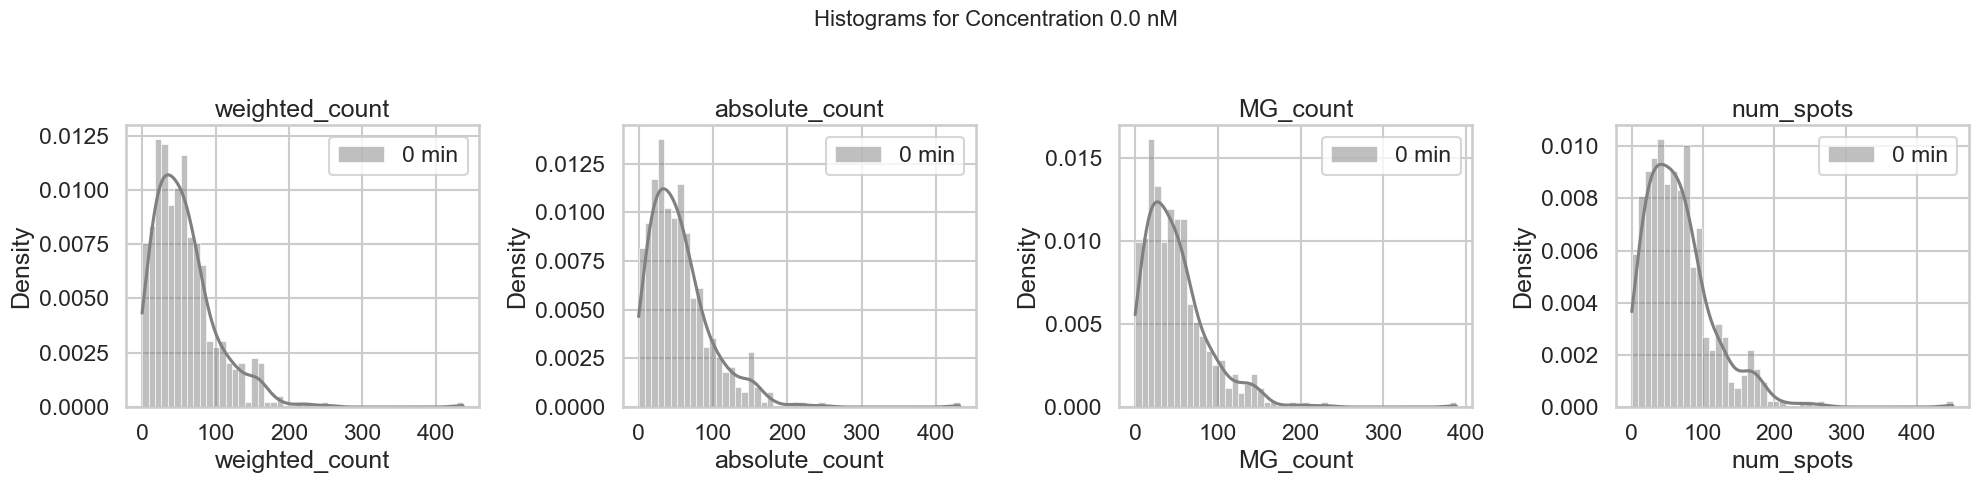

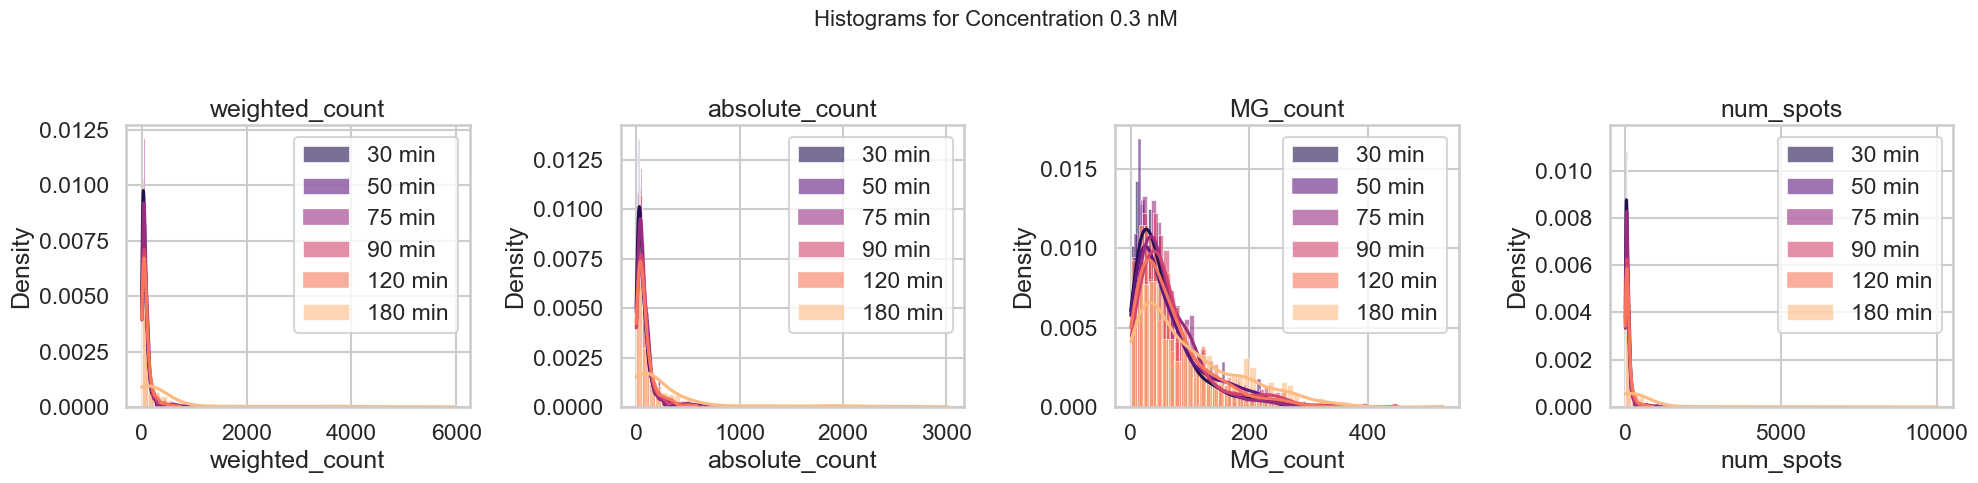

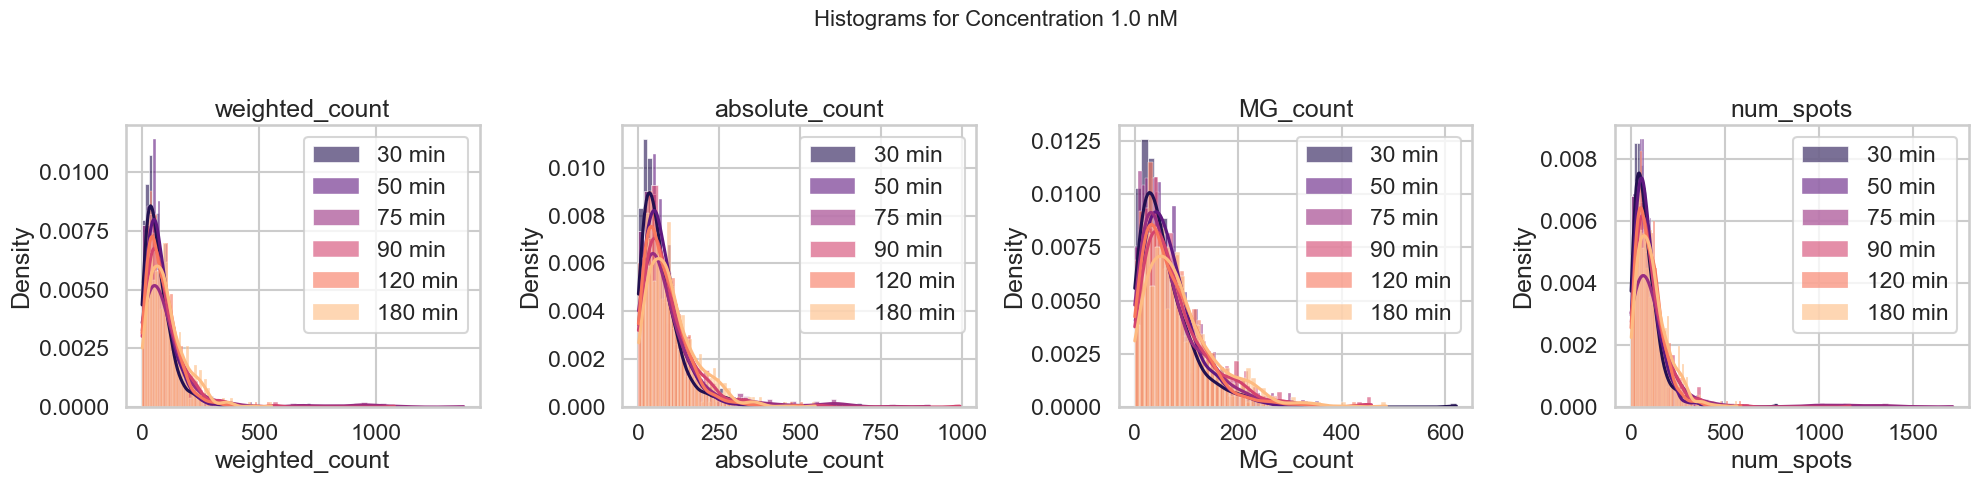

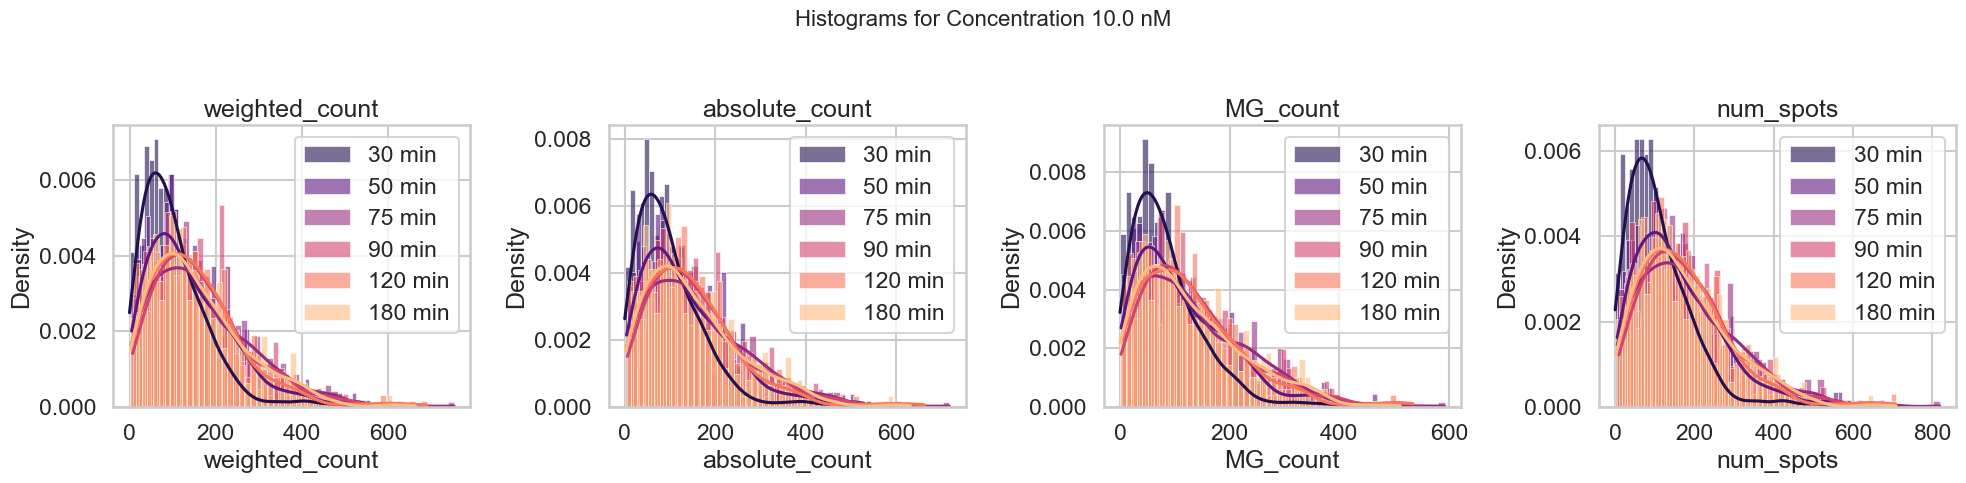

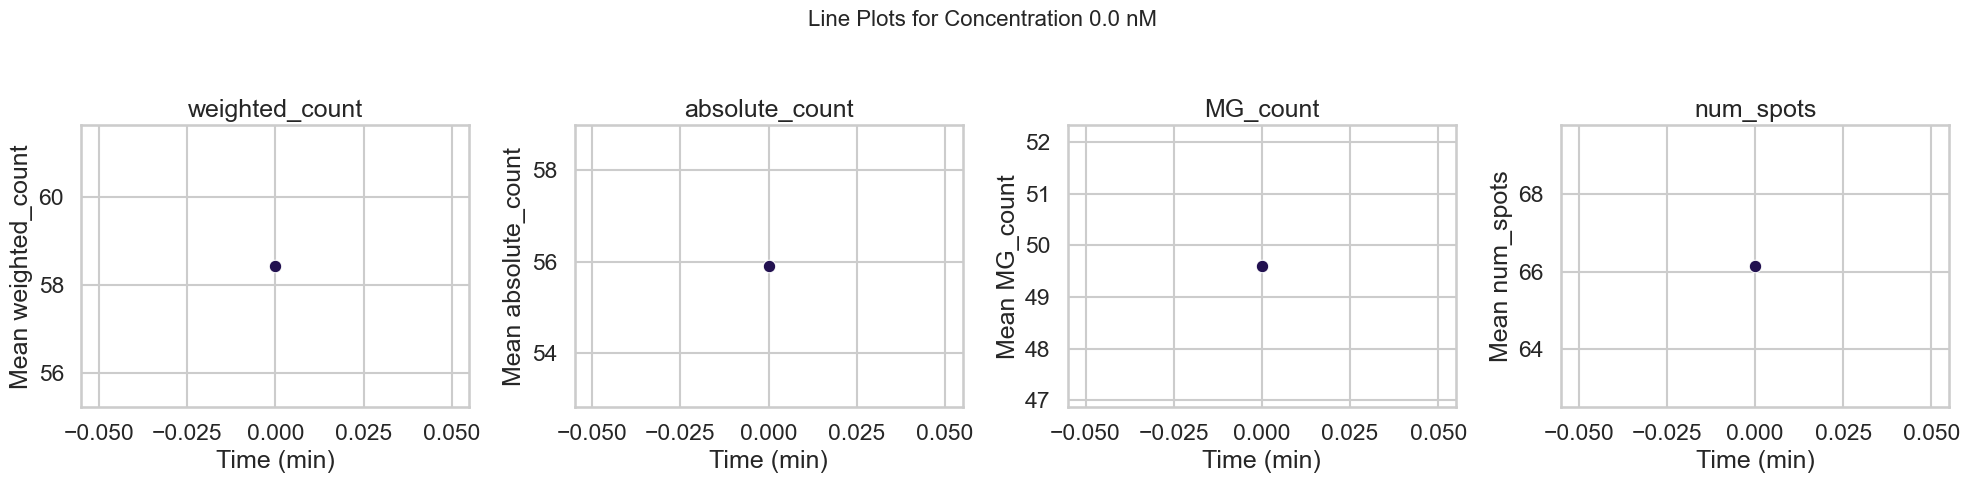

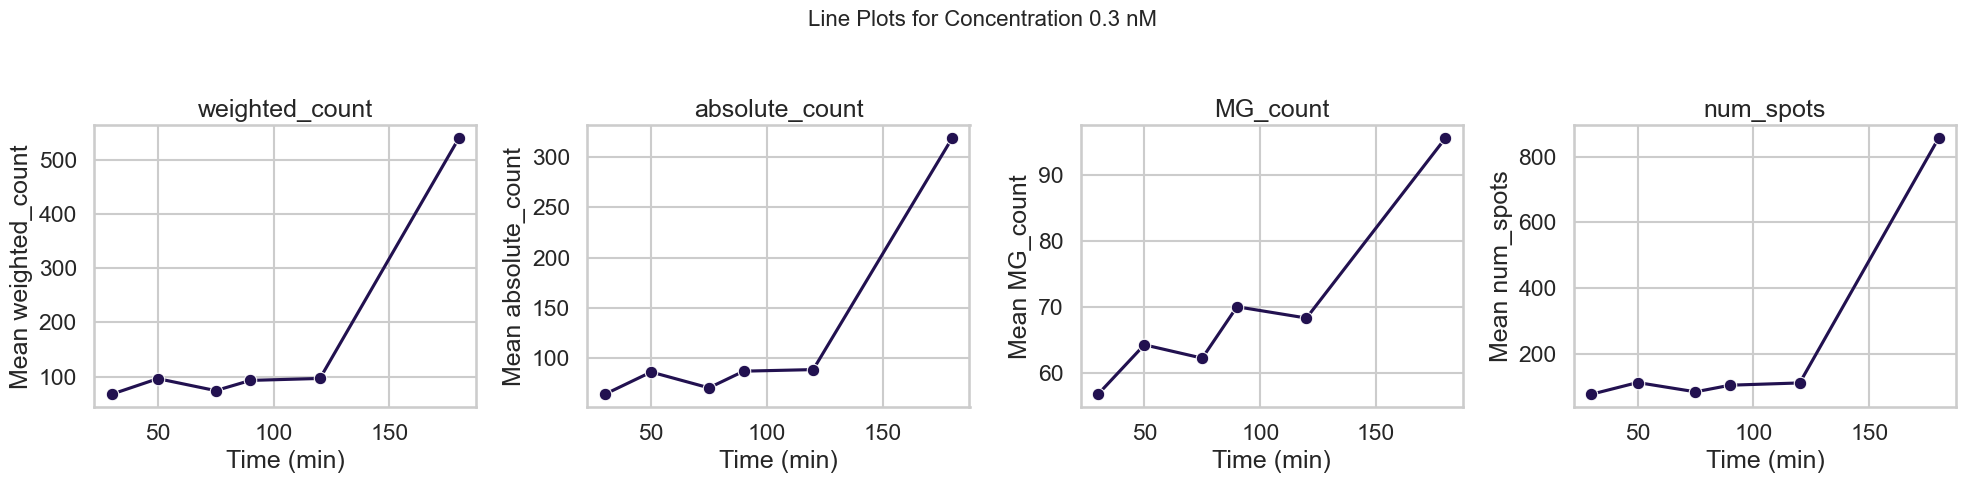

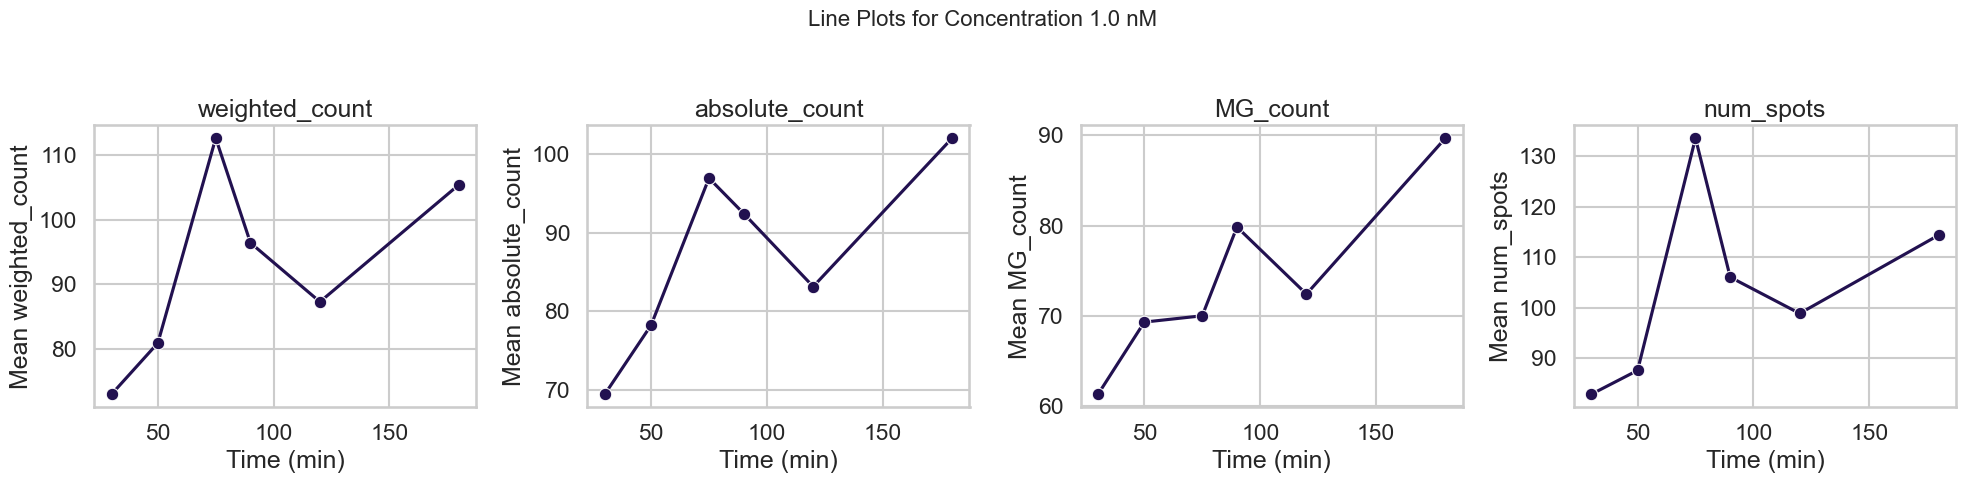

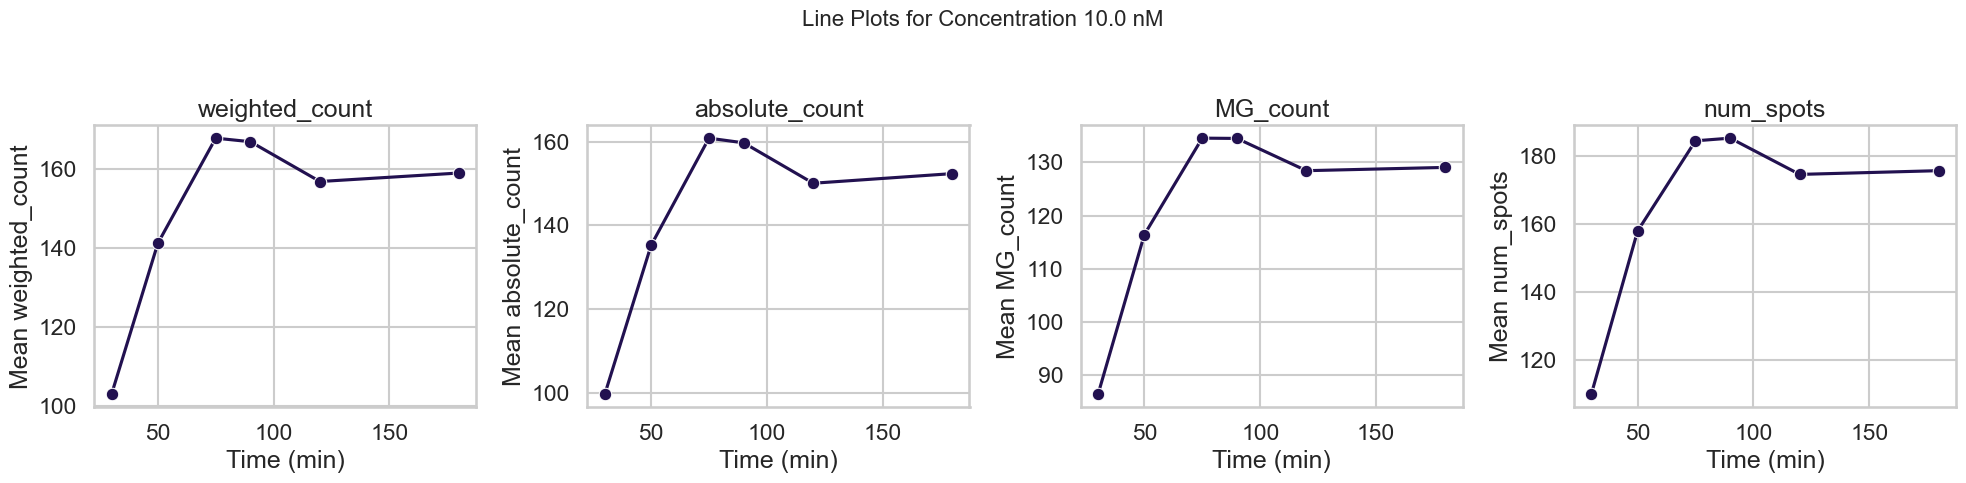

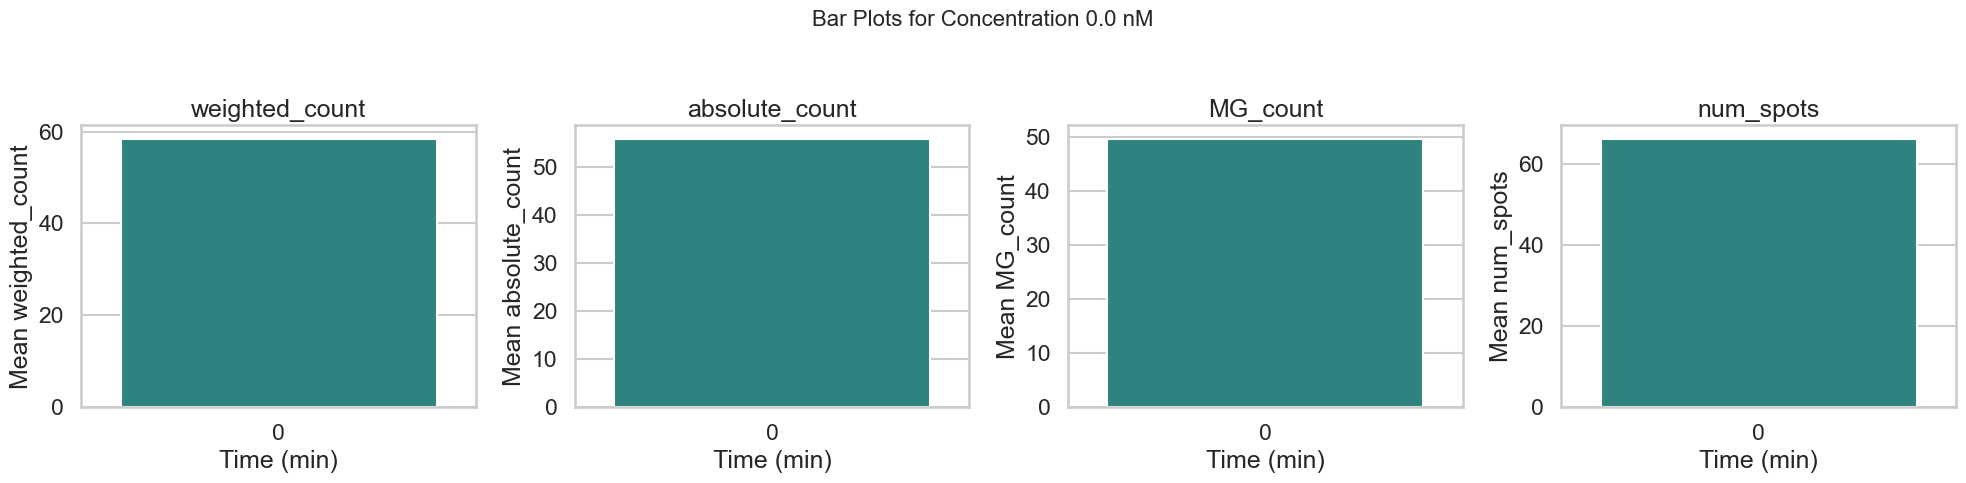

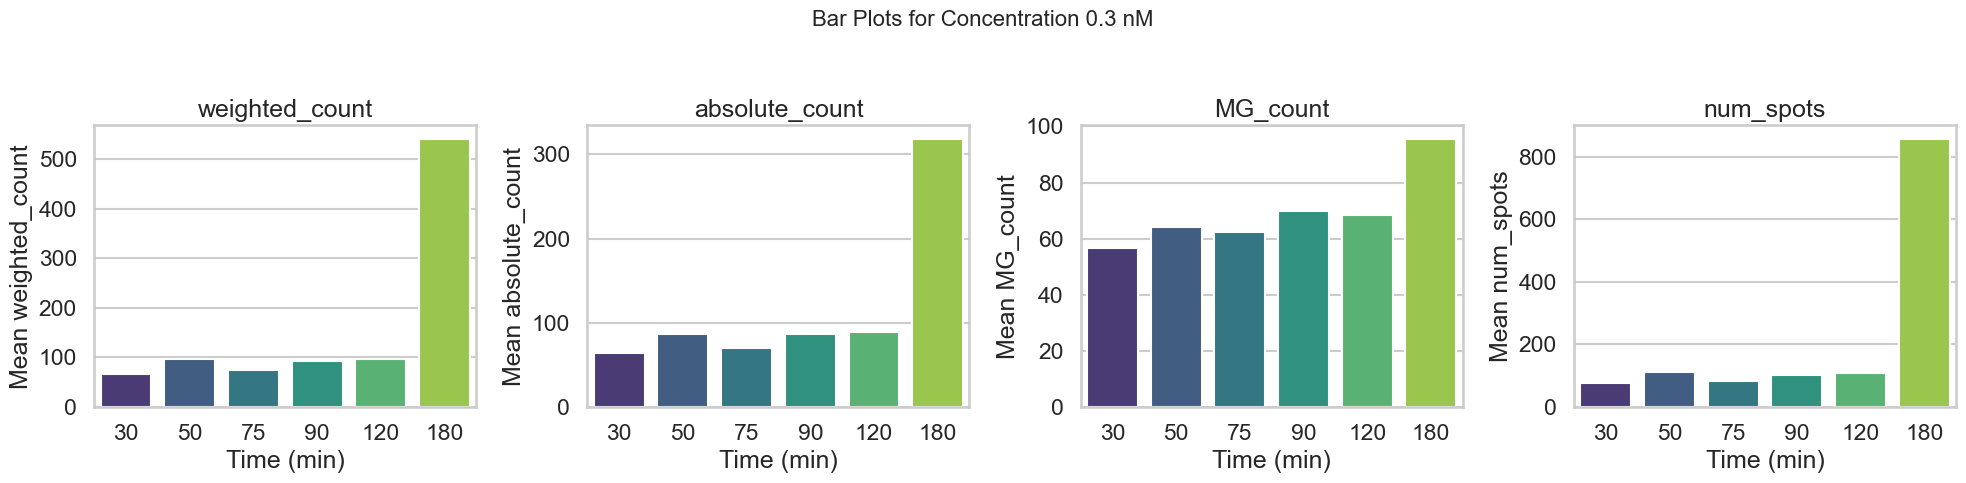

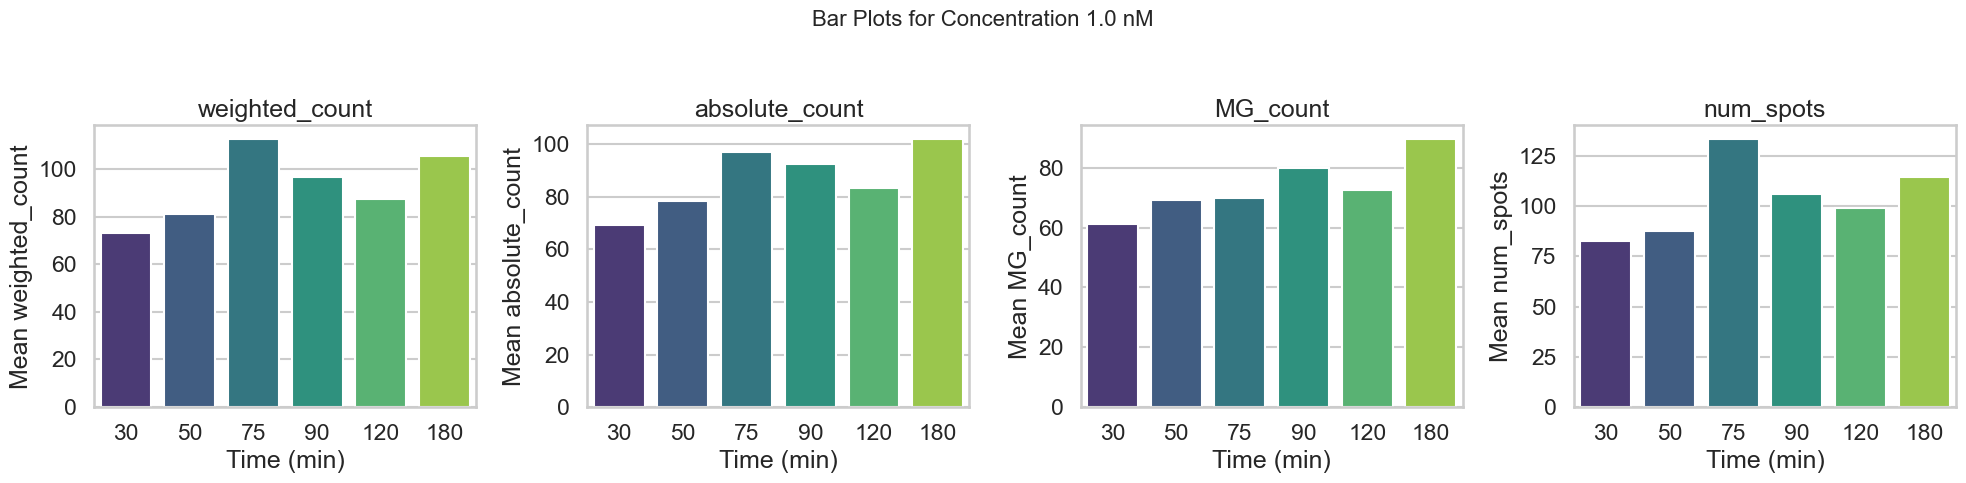

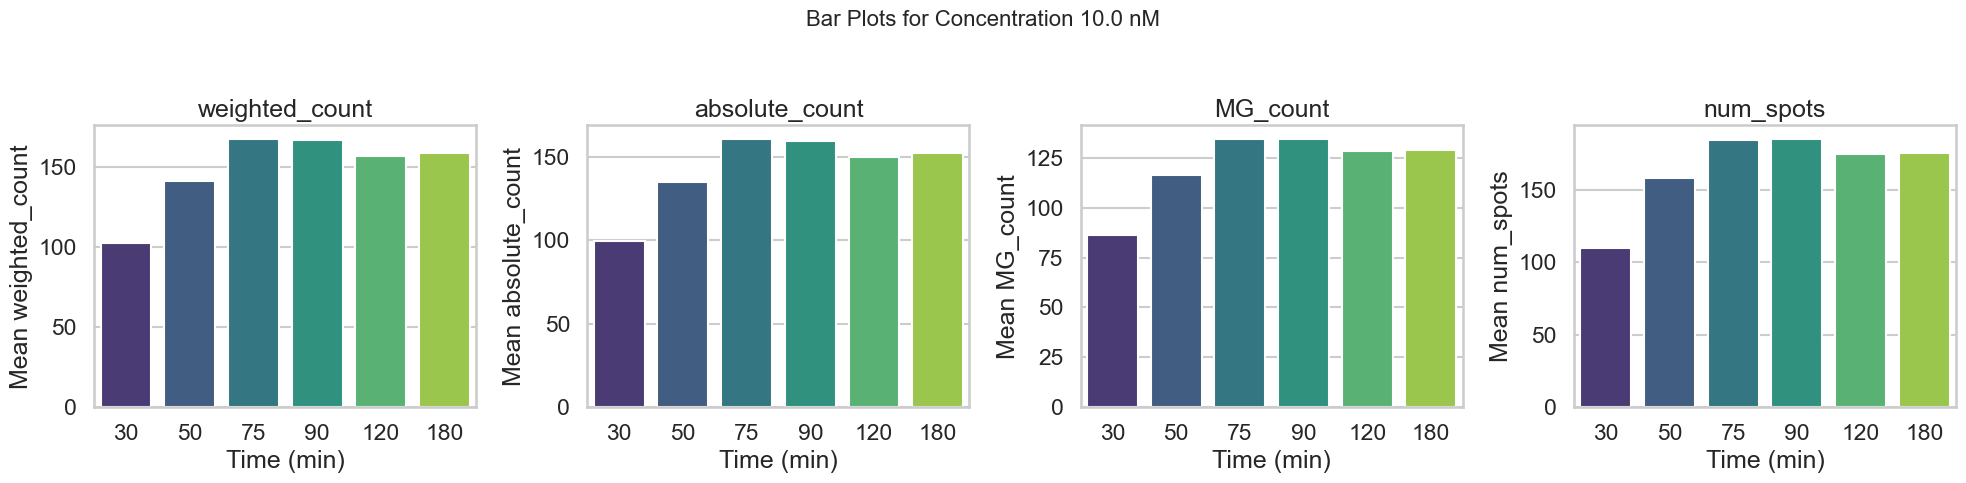

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# List of metrics corresponding to different thresholding methods
metrics = ['weighted_count', 'absolute_count', 'MG_count', 'num_spots']

# Ensure concentrations are sorted
concentrations = sorted(cell_level_results['dex_conc'].unique())

# Set common aesthetics
sns.set_context('talk')
sns.set_style('whitegrid')

# ========= 1. Histograms =========
# For each concentration, create a figure with a histogram for each metric.
for conc in concentrations:
    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    fig.suptitle(f'Histograms for Concentration {conc} nM', fontsize=16)
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        # Get baseline (0 min) data for the current concentration and plot histogram
        baseline = cell_level_results[(cell_level_results['dex_conc'] == conc) &
                                      (cell_level_results['time'] == 0)]
        sns.histplot(baseline[metric], bins=50, kde=True, color='gray', 
                     label='0 min', ax=ax, stat='density')
        
        # Get data for nonzero timepoints and overlay histograms
        nonzero = cell_level_results[(cell_level_results['dex_conc'] == conc) &
                                     (cell_level_results['time'] > 0)]
        timepoints = sorted(nonzero['time'].unique())
        for t in timepoints:
            subset = nonzero[nonzero['time'] == t]
            sns.histplot(subset[metric], bins=50, kde=True, ax=ax, 
                         label=f'{t} min', alpha=0.6, stat='density')
        
        ax.set_title(metric)
        ax.set_xlabel(metric)
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# ========= 2. Line Plots =========
# For each concentration, create a figure with a line plot for each metric.
# Here we plot the mean metric value over time (including 0 min).
for conc in concentrations:
    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    fig.suptitle(f'Line Plots for Concentration {conc} nM', fontsize=16)
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        # Group by time to compute the mean for each metric
        df_grouped = cell_level_results[cell_level_results['dex_conc'] == conc] \
                     .groupby('time')[metric].mean().reset_index()
        sns.lineplot(data=df_grouped, x='time', y=metric, marker='o', ax=ax)
        
        ax.set_title(metric)
        ax.set_xlabel('Time (min)')
        ax.set_ylabel(f'Mean {metric}')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# ========= 3. Bar Plots =========
# For each concentration, create a figure with a bar plot for each metric.
# Again, the bars display the average metric value at each timepoint.
for conc in concentrations:
    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    fig.suptitle(f'Bar Plots for Concentration {conc} nM', fontsize=16)
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        df_grouped = cell_level_results[cell_level_results['dex_conc'] == conc] \
                     .groupby('time')[metric].mean().reset_index()
        sns.barplot(data=df_grouped, x='time', y=metric, ax=ax, palette='viridis')
        
        ax.set_title(metric)
        ax.set_xlabel('Time (min)')
        ax.set_ylabel(f'Mean {metric}')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()